In [1]:
import re
import pandas as pd

# Wikipedia page (rendered version with minimal styling)
URL = "https://en.wikipedia.org/wiki/List_of_popes?action=render"

# Step 1: Read all tables from the page
tables = pd.read_html(URL)

# Step 2: Keep only tables that contain 'Pontificate' column (i.e., real popes list)
dfs = [df for df in tables if 'Pontificate' in df.columns]
df = pd.concat(dfs, ignore_index=True)

# Step 3: Normalize column names (replace non-breaking space, clean dots, trim spaces)
def normalize(col):
    return re.sub(r'\s*·\s*', ' · ', col.replace('\u00A0', ' ')).strip()

df.columns = [normalize(c) for c in df.columns]

# Step 4: Standardize variable column names across versions
df.rename(columns={
    **{c: 'Name: English · Latin' for c in df.columns if c.startswith('Name: English')},
    **{c: 'Age at start/end' for c in df.columns if c.lower().startswith('age at start')}
}, inplace=True)

# Step 5: Keep only relevant columns
KEEP = ['Pontiff number', 'Pontificate', 'Name: English · Latin',
        'Date and Place of birth', 'Age at start/end', 'Notes']

# Step 6: Final cleanup: remove empty rows, remove duplicate IDs, reset index
df = (df[KEEP]
        .dropna(subset=['Pontiff number'])
        .drop_duplicates('Pontiff number')
        .reset_index(drop=True))

# Output the shape for confirmation
print(df.shape)

(267, 7)


In [2]:
df.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267 entries, 0 to 266
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Pontiff number           267 non-null    object
 1   Pontificate              267 non-null    object
 2   Name: English · Latin    267 non-null    object
 3   Date and Place of birth  267 non-null    object
 4   Age at start/end         2 non-null      object
 5   Age at start/end         139 non-null    object
 6   Notes                    267 non-null    object
dtypes: object(7)
memory usage: 14.7+ KB


In [3]:
# Step 1: Temporarily rename two duplicate columns
df.columns.values[4] = 'Age at start/end_1'
df.columns.values[5] = 'Age at start/end_2'

# Step 2: Merge the two columns (keep non-empty values)
df['Age at start/end'] = df['Age at start/end_1'].combine_first(df['Age at start/end_2'])

# Step 3: Drop temporary columns
df.drop(columns=['Age at start/end_1', 'Age at start/end_2'], inplace=True)

In [4]:
df.head()

,Pontiff number,Pontificate,Name: English · Latin,Date and Place of birth,Notes,Age at start/end
0,1,30 â c. 64 (c. 34 years),St Peter PETRVS,"Bethsaida, Judaea, Roman Empire[birth 1]","Born as Shimon, son of Yonah, a Jew from Judae...",NaN
1,2,c. 64 â c. 76 (?) (11â12 years),St Linus LINVS,"Volterrae, Italia, Roman Empire[birth 2]","First Roman pope. Roman citizen, born in Itali...",NaN
2,3,c. 76 â c. 88 (?) (12 years),St Anacletus ANACLETVS,"Athenae, Achaea, Roman Empire[birth 4]","First Greek pope. A peregrinus, free provincia...",NaN
3,4,c. 88 â c. 97 (?) (9 years),St Clement I CLEMENS,"Roma, Italia, Roman Empire[birth 5]","Roman citizen, born in the capital of the Roma...",NaN
4,5,c. 97 â c. 105 (?) (7â8 years),St Evaristus EVARISTVS,"Bethlehem, Iudaea, Roman Empire[birth 6]","Hellenized Jew. A peregrinus, free provincial ...",NaN


In [5]:
df.tail()

,Pontiff number,Pontificate,Name: English · Latin,Date and Place of birth,Notes,Age at start/end
262,262,"21 June 1963 â 6 August 1978 (15 years, 46 d...",St Paul VI PAVLVS Sextus,"26 September 1897 Concesio, Italy","Motto: Cum Ipso in monte (""With Him on the mou...",65 / 80
263,263,26 August 1978 â 28 September 1978 (33 days),Bl. John Paul I IOANNES PAVLVS Primus,"17 October 1912 Forno di Canale, Italy","Motto: Humilitas (""Humility"") Italian citizen....",65 / 65
264,264,"16 October 1978 â 2 April 2005 (26 years, 16...",St John Paul II IOANNES PAVLVS Secundus,"18 May 1920 Wadowice, Poland","Motto: Totus tuus (""Totally yours"") Polish cit...",58 / 84
265,265,"19 April 2005 â 28 February 2013 (7 years, 3...",Benedict XVI BENEDICTVS Sextus Decimus,"16 April 1927 Marktl, Germany","Motto: Cooperatores veritatis (""Cooperators of...",78 / 85 (â 95)
266,266,"13 March 2013 â 21 April 2025 (12 years, 39 ...",Francis FRANCISCVS,"17 December 1936 Flores, Buenos Aires, Argentina","Motto: Miserando atque eligendo (""Lowly yet ch...",76 / 88


In [6]:
df.to_csv('popes_clean.csv', index=False, encoding='utf-8-sig')

In [8]:

# Pattern to extract phrases like "34 years"
YEAR_RE = re.compile(r'(\d+)\s*year')

# Pattern to extract durations like "(43 days)"
DAYS_RE = re.compile(r'\((\d+)\s*days\)')

def parse_fuzzy_year(text):
    """
    Parse approximate or fuzzy year formats like '198/9' or '199/200'
    Returns the average of the two values, or an int if clean.
    """
    if '/' in text:
        try:
            parts = text.strip().split('/')
            return (int(parts[0]) + int(parts[1])) / 2
        except:
            return None
    else:
        try:
            return int(text)
        except:
            return None

def years(pont):
    """
    Parse a papal reign string like:
    - '21 November 235 – 3 January 236 (43 days)'
    - '198/9 – 199/200 (1 year)'
    - '897 – 900'
    
    Returns:
        - Duration in years as float
        - None if parsing fails
    """
    if not isinstance(pont, str):
        return None

    # Case 1: match (xxx days)
    m = DAYS_RE.search(pont)
    if m:
        days = int(m.group(1))
        return round(days / 365, 2)

    # Case 2: match "34 years"
    m = YEAR_RE.search(pont)
    if m:
        years = int(m.group(1))
        return years if years >= 0 else None

    # Case 3: match year ranges like '198/9 – 199/200'
    if '–' in pont or '-' in pont:
        parts = re.split(r'[–-]', pont)
        if len(parts) == 2:
            start_year = parse_fuzzy_year(parts[0])
            end_year = parse_fuzzy_year(parts[1])
            if start_year is not None and end_year is not None and end_year >= start_year:
                return round(end_year - start_year + 1, 2)

    # Case 4: fallback if it contains a 4-digit year
    if re.search(r'\d{4}', pont):
        return 1  # Assume reign lasted one year

    # Log unrecognized entries
    print(f"Unrecognized entry: {pont}")
    return None

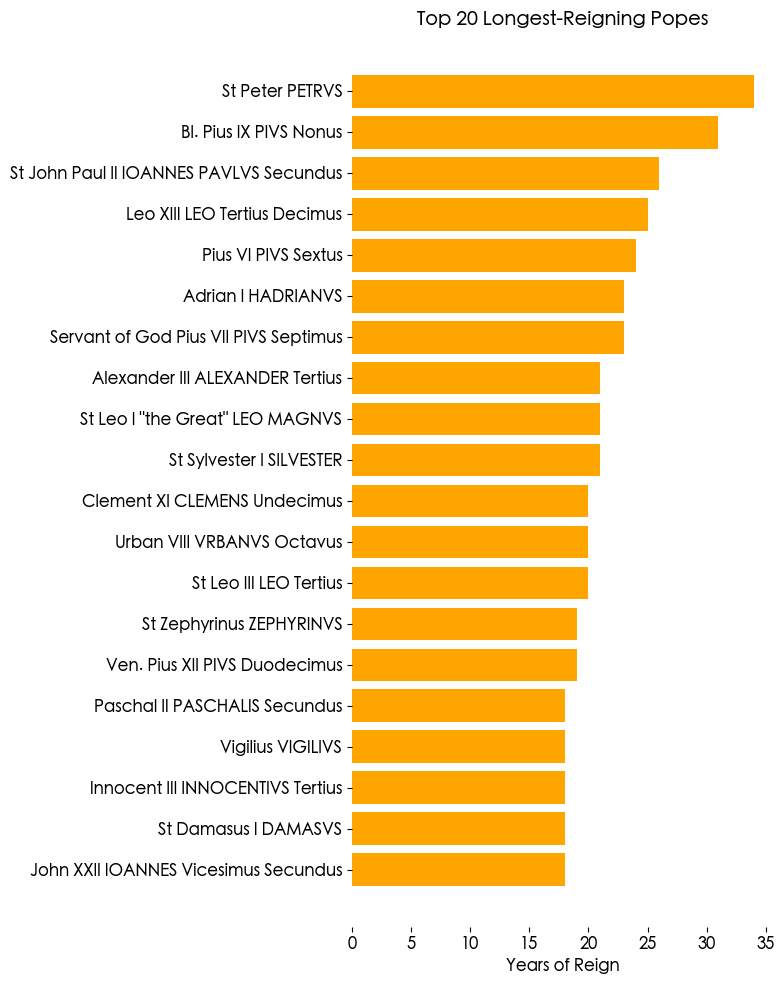

In [9]:
import matplotlib.pyplot as plt

# Apply the 'years' function to extract reign duration
df['Reign_years'] = df['Pontificate'].apply(years)

# Select top 20 longest-reigning popes
top20 = (df.dropna(subset=['Reign_years'])
           .sort_values('Reign_years', ascending=False)
           .head(20))

# Create a horizontal bar chart
plt.figure(figsize=(8, 10))
plt.barh(top20['Name: English · Latin'], top20['Reign_years'], color='orange')
plt.xlabel('Years of Reign')
plt.title('Top 20 Longest-Reigning Popes')

# Invert the y-axis so the longest reign is on top
plt.gca().invert_yaxis()

# Remove all chart spines (outer borders)
ax = plt.gca()
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

# Auto-adjust layout to avoid clipping
plt.tight_layout()

# Display the plot
plt.show()

In [10]:
df.to_csv('popes_with_reign_years.csv', index=False, encoding='utf-8-sig')

In [11]:
# Count and show entries with unrecognized reign years
missing_rows = df[df['Reign_years'].isna()]
print(f'Unrecognized reign years: {len(missing_rows)}')
print(missing_rows)

# Count and show entries with negative reign years
negative_rows = df[df['Reign_years'] < 0]
print(f'Negative reign years: {len(negative_rows)}')
print(negative_rows)

# Calculate and display the average reign duration
avg = df['Reign_years'].mean()
print(f'Average reign duration: {avg:.2f} years')

Unrecognized reign years: 0
Empty DataFrame
Columns: [Pontiff number, Pontificate, Name: English · Latin, Date and Place of birth, Notes, Age at start/end, Reign_years]
Index: []
Negative reign years: 0
Empty DataFrame
Columns: [Pontiff number, Pontificate, Name: English · Latin, Date and Place of birth, Notes, Age at start/end, Reign_years]
Index: []
Average reign duration: 6.91 years


In [12]:
print(df.nlargest(10, 'Reign_years')[['Pontificate', 'Reign_years']])

                                           Pontificate  Reign_years
0                           30 â c. 64 (c. 34 years)         34.0
255  16 June 1846 â 7 February 1878 (31 years, 23...         31.0
264  16 October 1978 â 2 April 2005 (26 years, 16...         26.0
256  20 February 1878 â 20 July 1903 (25 years, 1...         25.0
250  15 February 1775 â 29 August 1799 (24 years,...         24.0
95   1 February 772 â 26 December 795 (23 years, ...         23.0
251  14 March 1800 â 20 August 1823 (23 years, 15...         23.0
33   31 January 314 â 31 December 335 (21 years, ...         21.0
45   29 September 440 â 10 November 461 (21 years...         21.0
170  7 September 1159 â 30 August 1181 (21 years,...         21.0


In [ ]:
%pip install geopandas
%pip install geopy
%pip install contextily
%pip install shapely
%pip install folium

In [13]:
import pandas as pd, geopandas as gpd, folium, re, time
from geopy.geocoders import Nominatim
from shapely.geometry import Point
from tqdm import tqdm

# --------- 1. Read CSV ----------
df = pd.read_csv('popes_with_reign_years.csv')

# --------- 2. Extract Place ---------
def place_full(text: str):
    """
    Extract location part after the 4-digit birth year.
    E.g., '1890 Concesio, Italy' → 'Concesio, Italy'
    """
    if isinstance(text, str):
        text = re.sub(r'\[.*?\]', '', text)  # remove [1] references
        m = re.search(r'\b\d{4}\b\s+(.+)$', text.strip())
        return m.group(1).strip() if m else None
    return None

df['Place'] = df['Date and Place of birth'].apply(place_full)

# --------- 3. Geocode (with cache) ----------
geolocator = Nominatim(user_agent='pope-birth-map', timeout=10)
cache_file = 'place_cache.csv'

# Load cache if available
try:
    cache_df = pd.read_csv(cache_file)
    cache = {row['place']: {'lat': row['lat'], 'lon': row['lon']} for _, row in cache_df.iterrows()}
except FileNotFoundError:
    cache = {}

# Lookup lat/lon
lats, lons = [], []

for place in tqdm(df['Place']):
    if place in cache:
        lat, lon = cache[place]['lat'], cache[place]['lon']
    else:
        try:
            loc = geolocator.geocode(place)
            lat, lon = (loc.latitude, loc.longitude) if loc else (None, None)
        except Exception as e:
            lat, lon = None, None
        cache[place] = {'lat': lat, 'lon': lon}
        time.sleep(1)  # Nominatim rate limit

    lats.append(lat)
    lons.append(lon)

df['lat'], df['lon'] = lats, lons

# Save cache safely
pd.DataFrame.from_dict(cache, orient='index').reset_index(names='place').to_csv(cache_file, index=False)

# Drop rows where geocoding failed
df = df.dropna(subset=['lat', 'lon'])

100%|██████████| 267/267 [00:01<00:00, 148.69it/s]


In [15]:
from folium.plugins import Search
import matplotlib.pyplot as plt  # For color gradients
import matplotlib.cm as cm
import matplotlib.colors as colors
import geopandas as gpd

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['lon'], df['lat']),
    crs="EPSG:4326"  # WGS84 coordinate system
)

# 1. Normalize color mapping
norm = colors.Normalize(vmin=gdf['Reign_years'].min(), vmax=gdf['Reign_years'].max())
cmap = cm.get_cmap('YlOrRd')

# 2. Construct GeoJson Feature collection
features = []
for _, row in gdf.iterrows():
    name = row['Name: English · Latin']
    popup = f"<b>{name}</b><br>Reigned: {row['Reign_years']} years"
    color = colors.to_hex(cmap(norm(row['Reign_years'])))
    radius = min(max(row['Reign_years'] * 0.6, 3), 20)

    feature = {
        "type": "Feature",
        "geometry": {
            "type": "Point",
            "coordinates": [row['lon'], row['lat']],
        },
        "properties": {
            "name": name,
            "popup": popup,
            "color": color,
            "radius": radius
        }
    }
    features.append(feature)

geojson = {
    "type": "FeatureCollection",
    "features": features
}

# 3. Create the map and load GeoJson
m = folium.Map(location=[41.9, 12.5], zoom_start=3)

geojson_layer = folium.GeoJson(
    geojson,
    name="Popes",
    tooltip=folium.GeoJsonTooltip(fields=["name"]),
    popup=folium.GeoJsonPopup(fields=["popup"]),
    marker=folium.CircleMarker(),  # Not functional, use style_function for styling
    style_function=lambda feature: {
        'fillColor': feature['properties']['color'],
        'color': feature['properties']['color'],
        'radius': feature['properties']['radius'],
        'fillOpacity': 0.7,
        'weight': 1
    }
)
geojson_layer.add_to(m)

# 4. Add search functionality
Search(
    layer=geojson_layer,
    search_label='name',
    placeholder='Search Pope by name...',
    collapsed=False
).add_to(m)

m.save("pope_birthplaces.html")
print("✅ Generated GeoJson map with search functionality: pope_birthplaces.html")


✅ Generated GeoJson map with search functionality: pope_birthplaces.html


/var/folders/rz/3t1t73yj305fvj2vckvctvj40000gn/T/ipykernel_53176/1202644895.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('YlOrRd')
